In [221]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [222]:
import pandas as pd
import numpy as np

from pandas.plotting import scatter_matrix
from seaborn import scatterplot, heatmap, barplot

from sklearn.model_selection import train_test_split

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler

from sklearn.preprocessing import OneHotEncoder

from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.linear_model import Ridge, LinearRegression
from sklearn.neighbors import KNeighborsRegressor

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate

from sklearn.metrics import mean_absolute_error

from joblib import dump

## IMPORTANT NOTE
- its come to my attention upon reading the submission page again that i should have set basesalary as the target value. when completing this originally i assumed that totalyearlycompensation would be a better target but the submission specifically states it wants base salary.
- this could be relativiely easily ammended by changing a few lines of code but i worry that doing that at this late stage will cause errors that i wont have time to fix.
- so ive kept my target as TYC and accept all negative ramifications (although if anything using TYC as the target is more difficult anyyway)

In [223]:
url = 'https://raw.githubusercontent.com/derekgbridge/artificial_intelligence/master/ai1/datasets/dataset_salaries.csv'
df = pd.read_csv(url)


In [224]:
# shuffle our data to remove any unwanted ordering 
df = df.sample(frac=1, random_state=2)
df.reset_index(drop=True, inplace=True)

In [225]:
#We then have a look at columns and values 
df.head()

,timestamp,company,level,title,totalyearlycompensation,location,yearsofexperience,yearsatcompany,tag,basesalary,stockgrantvalue,bonus,gender,otherdetails,cityid,dmaid,rowNumber
0,11/3/2020 10:26:30,Microsoft,60,Data Scientist,181,"Redmond, WA",1,1,ML / AI,104,47,30,Male,mckeiaps hash ghaart gronds wuit zearts tsiott...,11521,819.0,47529
1,8/14/2018 21:08:29,VMware,Senior MTS,Software Engineer,0,"Palo Alto, CA",5,3,Full Stack,0,0,0,NaN,NaN,7351,807.0,1418
2,5/18/2019 0:32:17,Paypal,T25,Software Engineer,213,"San Francisco, CA",7,1,API Development (Back-End),180,19,14,Male,NaN,7419,807.0,8815
3,8/3/2021 20:25:07,Trend Micro,Senior Engineer,Software Engineer,18,"Taipei, TP, Taiwan",2,2,Distributed Systems (Back-End),14,1,3,Male,mcclieusp hyoully preebly gloiands screoch sch...,6744,0.0,81297
4,5/3/2021 15:25:42,Visa,Senior Software Engineer,Software Engineer,179,"Austin, TX",3,0,Full Stack,158,9,12,Female,dyniawn cauny spliur cleals crungs kwoiw thrai...,10965,635.0,68303


In [226]:
df.columns

Index(['timestamp', 'company', 'level', 'title', 'totalyearlycompensation',
       'location', 'yearsofexperience', 'yearsatcompany', 'tag', 'basesalary',
       'stockgrantvalue', 'bonus', 'gender', 'otherdetails', 'cityid', 'dmaid',
       'rowNumber'],
      dtype='object')

## Given I intend on making 'TotalYearlyCompensation' as the target i can make the following removals from the dataset

### Easy Ones
- Timestamp -> No relation to target
- rowNumber -> No relation to target 
-  OtherDetails -> Going to be way too random evidenced by the fact that the most common of all 40,132 was the cryptic 'twauesly' with a total of 2 entries, hypathetically you could some NLP to get similarities across entries, but I lack the skill and the will

In [227]:
columns_to_remove = ['timestamp','rowNumber', 'otherdetails']
df.drop(columns_to_remove,axis=1, inplace=True)
df.reset_index(drop=True, inplace=True)

## Looking at the remaining columns, theres are more I would like to remove that require more explaination 
- Having looked at levels.fyi itself i can see it asks for base salary, bonus and stock info and one can assume that the data set then adds these 3 together to get totalYearlyCompensation. Given that TYC is directly made up of **base salary**, **bonus** and **stock info** we must remove them if we want a usuable model. (otherwise we'd be making a salary 'predictor' that asks for you base salary, bonus, and stocks which would be kind of insulting). 
Upon looking further at the dataset it seems that this isnt the case, there is an upload option on levels.fyi which i assume is where its getting its TYC figure because is certainly isn't the 3 other columns added together. My plan now is to make TYC the sum of the other 3 columns and remove them.
- Next is **DmaID** which all rows have and has a min of 0 and max of 881 which is kind of weird given the fact theres 62640 rows but nonetheless given its unknown nature ill remove it 
-  **cityID** -> We have location already, which is in neat format given its forced to be in levels.fyi's dropdown menu, so cityID seems redundant. Also as a final product i would like if all the column values the model looks for to be human iterpretable, so potentially i could put in my details and get my estimate, Whats my City ID? Ive no idea, removed.
Also, most importantly this is an example of an unordered nominal values which might cause the algorithm to assume that id's nearer each are more related which for city id's i see no reason as to why they would be 




In [228]:
columns_to_remove = ['cityid', 'dmaid']
df.drop(columns_to_remove,axis=1, inplace=True)
df.reset_index(drop=True, inplace=True)

## Now well consider the money related fields
- it seems all money related values have been divided by 1,000 so we'll have to think of them as units of thousands 
-  Ive realised its quite complicated to work out what an unresonable low salary would be in this dataset given that i cannot see the currency but ill try nonetheless
- suppsosing that people working full time work 39 hours per week for 52 weeks of the year 39x52 = 2028 x (lets say 10 units of currency per hour minimum) = 20280 yearly salary. Lets call it 20,000 to be safe and remove all less than that 
-  lets assume that anyone making more that 500,000 base a year is lying, now many of them wont be but given how easy it is to lie id have to assume the majority over this limit are 
-  Lets also make some assumptions about stock and bonus which are realitive to base salary 


In [229]:
df['basesalary'].value_counts().describe()

count    1263.000000
mean       49.597783
std       119.598045
min         1.000000
25%         1.000000
50%         1.000000
75%        14.000000
max      2304.000000
Name: basesalary, dtype: float64

In [230]:
# set our min and max
df = (df[(df["basesalary"] >= 20) & (df["basesalary"] < 500)]).copy()

# lets assume no one is making a bonus more that the 1.5x the size of the base salary
df = df[(df['bonus'] <= (df['basesalary']*1.5))].copy()

#lets assume that also no one is getting stocks more than 2x their base salary
df = df[(df['stockgrantvalue'] <= (df['basesalary']*2))].copy()

# remove this gender
df = df[(df['gender'] != 'Title: Senior Software Engineer')].copy()

## Looking at the head of the dataset its become clear that 'totalYearlyCompensation' is in fact *not always* the adding together of basesalary,bonus and stockgrant value. Id guess this is becuase the levels.fyi site also includes a commission option which is missing in our dataset.
## In my model it will be, so will will add them together and then remove basesalary,bonus and stockgrant value 

In [231]:
df['totalyearlycompensation'] = df['basesalary'] + df['bonus'] + df['stockgrantvalue']
money_columns_remove = ['basesalary', 'bonus', 'stockgrantvalue']
df.drop(money_columns_remove,axis=1, inplace=True)
df.reset_index(drop=True, inplace=True)

In [232]:
df.shape

(57614, 9)

## Finally Im going to handle some of the NaNs. It might be a good idea, given the dataset size to do so, but for most columns all will allow NaNs to be handled by a SimpleImputer later on

- ill try to remove NaNs for column in which I think it would be most inaccurate to replace the value with a mean or mode


In [233]:
# Delete examples where values are NaN
df.dropna(subset=["totalyearlycompensation", "yearsofexperience", "yearsatcompany", "tag", "level"], inplace=True)

## I am now happy that all data seems reasonable, now I must handle the really big nominal value columns

In [234]:
df.reset_index(drop=True, inplace=True)
d = {}
for column in df.columns:
    d[column] = (df[column].unique()).size    
d

{'company': 1816,
 'level': 2912,
 'title': 15,
 'totalyearlycompensation': 865,
 'location': 1017,
 'yearsofexperience': 56,
 'yearsatcompany': 41,
 'tag': 3101,
 'gender': 4}

## I was tempted to remove more columns ('tags' & 'level') because they are nominal features that have too many unique values to sensible one-hot encode (I'd end up with 6000+ more columns which seems dumb) but then I started Googling because surely this is a common issue....


## And came to the conclusion that there's a few different ways to tackle this:
### Option 1 
- Use different encoders. Followed This: [link](https://towardsdatascience.com/smarter-ways-to-encode-categorical-data-for-machine-learning-part-1-of-3-6dca2f71b159 "Researched Here").
    - Binary Encoders (reduces dimensionality)
    - Bayesian Encoders like Target, LeaveOneOut (seem the most complex invovles columns ratio to target which seems to highten both overfitting and leakage 

### Option 2
- Try to reduce the number of rows in a column by grouping
    - for tags could only use the most common tags, say N, and put the rest as other 
    - for location, given the data format, could easily change from "city, county, country" to just "country"

### Option 3
- Or a **combination of both**

## My idea is to take the Top N responses in the columns 'tag', 'levels' and 'company' and set the values to all remaining responses to 'other'

- Cleary "n" here is something I can play around with but I read a good idea is to ensure the 'Other' option doesnt become more>50% for each respective option

In [235]:
columns_to_add_other = ['tag', 'level', 'company']
# I select the 200 most common responses
n = 250
for column in columns_to_add_other:
  most_common = df[column].value_counts()[:n].index.tolist()
  # And replace all values not in that 150 with 'Other'
  df.loc[~df[column].isin(most_common), column] = "Other"

In [236]:
most_common_levels_including_other = df['level'].value_counts()[:n].index.tolist()
# get count of occurences for each value in top 150 
levels_d = {}
for value in most_common_levels_including_other:
    levels_d[value] = df['level'].value_counts()[value]
levels_d

{'Other': 6616,
 'L4': 4689,
 'L5': 4498,
 'L3': 3163,
 'L6': 2490,
 'Senior Software Engineer': 1262,
 'L2': 1101,
 'Senior': 917,
 'L1': 722,
 '62': 711,
 '63': 693,
 'ICT4': 690,
 'E5': 681,
 'Software Engineer': 671,
 '61': 656,
 'L7': 649,
 'IC3': 619,
 'IC4': 618,
 'ICT3': 591,
 'E4': 587,
 '60': 556,
 '64': 553,
 'SDE II': 512,
 'Associate': 505,
 '59': 499,
 'IC5': 455,
 'SDE I': 418,
 'Analyst': 398,
 'E3': 373,
 'Senior MTS': 370,
 'Senior Engineer': 360,
 '65': 356,
 'Manager': 356,
 'P3': 343,
 'P4': 338,
 'IC2': 335,
 'Staff Software Engineer': 328,
 'Staff Engineer': 293,
 'Director': 291,
 'Senior Associate': 276,
 'Grade 8': 274,
 'Grade 6': 260,
 'Vice President': 240,
 'Software Engineer II': 240,
 'L6 SDM': 225,
 '2': 212,
 'P2': 210,
 'Software Engineer 2': 209,
 'Consultant': 204,
 'Grade 7': 202,
 '66': 199,
 '4': 198,
 'E6': 197,
 'IC-3': 197,
 'Senior Manager': 197,
 'Senior Consultant': 195,
 '1': 192,
 'L8': 185,
 'IC-2': 185,
 'Grade 10': 183,
 '5': 181,
 'T4

In [237]:
most_common_company_including_other = df['company'].value_counts()[:n].index.tolist()

# get count of occurences for each value in top 150 
compnay_d = {}
for value in most_common_company_including_other:
    compnay_d[value] = df['company'].value_counts()[value]
compnay_d

{'Other': 8649,
 'Amazon': 6965,
 'Microsoft': 4678,
 'Google': 3901,
 'Facebook': 2639,
 'Apple': 1845,
 'Oracle': 1004,
 'Salesforce': 960,
 'Intel': 879,
 'Cisco': 825,
 'IBM': 810,
 'Uber': 766,
 'Capital One': 736,
 'LinkedIn': 611,
 'VMware': 610,
 'Qualcomm': 522,
 'Bloomberg': 513,
 'JPMorgan Chase': 509,
 'Goldman Sachs': 443,
 'Intuit': 412,
 'PayPal': 395,
 'Deloitte': 376,
 'Twitter': 364,
 'Walmart Labs': 357,
 'Adobe': 352,
 'Expedia': 338,
 'Nvidia': 336,
 'Wayfair': 319,
 'Accenture': 313,
 'eBay': 303,
 'SAP': 293,
 'Lyft': 285,
 'Workday': 241,
 'Shopify': 226,
 'Dropbox': 216,
 'Dell Technologies': 204,
 'Visa': 202,
 'Atlassian': 201,
 'Airbnb': 194,
 'Yelp': 186,
 'ServiceNow': 175,
 'Tesla': 168,
 'Yahoo': 168,
 'Snap': 162,
 'Square': 162,
 'ByteDance': 159,
 'Indeed': 158,
 'Stripe': 157,
 'Zillow': 155,
 'Splunk': 148,
 'Comcast': 147,
 'Nutanix': 132,
 'T-Mobile': 131,
 'Netflix': 130,
 'Broadcom': 128,
 'General Motors': 128,
 'Spotify': 127,
 'Boeing': 126,


In [238]:
most_common_tag_including_other = df['tag'].value_counts()[:n].index.tolist()

# get count of occurences for each value in top 150
tag_d = {}
for value in most_common_tag_including_other:
    tag_d[value] = df['tag'].value_counts()[value]
tag_d

{'Full Stack': 10500,
 'Distributed Systems (Back-End)': 9836,
 'API Development (Back-End)': 5804,
 'Other': 4024,
 'ML / AI': 3753,
 'Web Development (Front-End)': 2719,
 'Product': 1701,
 'Data': 1528,
 'DevOps': 1438,
 'Security': 1088,
 'Networking': 1081,
 'iOS': 1048,
 'Android': 867,
 'Mobile (iOS + Android)': 821,
 'Technical': 764,
 'Testing (SDET)': 740,
 'Site Reliability (SRE)': 721,
 'User Experience (UX)': 671,
 'General': 660,
 'Production': 491,
 'Operations': 320,
 'Enterprise': 305,
 'Consumer': 268,
 'ASIC Design': 263,
 'Analytic': 202,
 'Hardware': 183,
 'Cloud': 182,
 'Verification': 181,
 'SoC Design': 176,
 'Embedded': 163,
 'Sales': 158,
 'Growth': 151,
 'Analytics': 133,
 'Analog': 131,
 'Embedded Systems': 131,
 'Validation': 114,
 'Design': 110,
 'Infrastructure': 97,
 'Firmware': 78,
 'Marketing': 74,
 'Strategy': 70,
 'Interaction Design': 66,
 'Internal': 66,
 'AWS': 61,
 'Machine Learning': 52,
 'Finance': 51,
 'Consulting': 51,
 'Data Science': 51,
 'A

In [239]:
df.reset_index(drop=True, inplace=True)
d = {}
for column in df.columns:
    d[column] = (df[column].unique()).size    
d


{'company': 251,
 'level': 251,
 'title': 15,
 'totalyearlycompensation': 865,
 'location': 1017,
 'yearsofexperience': 56,
 'yearsatcompany': 41,
 'tag': 250,
 'gender': 4}

## Now onto location
- so for this ill do some regex to grab everything after the last comma and just use that. 

In [240]:
df['location'] = df['location'].str.extract(r'.*,\s*(?:\d+\s*)?([^\d,]+?)(?:\s*\d+)?$', expand=False)


In [241]:
df['location'].unique()


array(['WA', 'CA', 'TX', 'NY', 'India', 'IL', 'Germany', 'Canada', 'OR',
       'AZ', 'WI', 'Singapore', 'NC', 'Hungary', 'VA', 'United Kingdom',
       'MA', 'SC', 'AR', 'South', 'Russia', 'PA', 'NJ', 'DC', 'MN', 'LA',
       'Australia', 'GA', 'IN', 'Ireland', 'Switzerland', 'CO',
       'Luxembourg', 'MI', 'DE', 'NM', 'TN', 'KS', 'NH', 'FL', 'ID', 'OH',
       'Thailand', 'Ukraine', 'Indonesia', 'Taiwan', 'Czech Republic',
       'NE', 'Israel', 'Japan', 'China', 'NV', 'CT', 'UT', 'MO',
       'Romania', 'France', 'Netherlands', 'Spain', 'IA', 'Denmark', 'RI',
       'ME', 'MD', 'Italy', 'United Arab Emirates', 'Estonia', 'Poland',
       'Hong Kong (SAR)', 'United States', 'Brazil', 'Yugoslavia',
       'Qatar', 'Norway', 'KY', 'Sweden', 'WV', 'AL', 'Argentina', 'MT',
       'OK', 'Mexico', 'Peru', 'Bulgaria', 'Belgium', 'New Zealand',
       'Jordan', 'Finland', 'Serbia', 'South Africa', 'Colombia', 'VT',
       'Chile', 'Turkey', 'Portugal', 'ND', 'Slovakia', 'Malaysia',
       '

## Seems good enough. Im fine with american states being included as 2 letter symbols as they seem to be consisitantly across the board

## Now we create our test set 

In [242]:
# Split off the test set: 20% of the dataset.
dev_df, test_df = train_test_split(df, train_size=0.8, random_state=2)

## Data Exploration

In [243]:
# Now well create a copy to explore the data further 
copy_df = dev_df.copy()

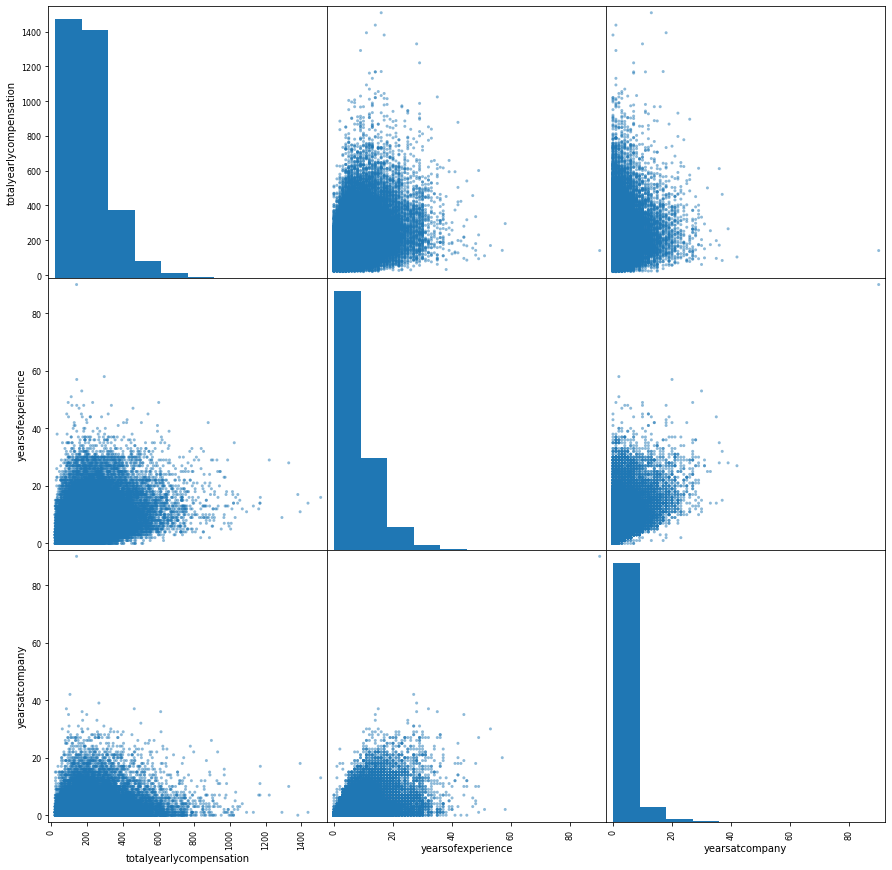

In [244]:
m = scatter_matrix(copy_df, figsize=(15, 15))

In [245]:
copy_df.corr()

,totalyearlycompensation,yearsofexperience,yearsatcompany
totalyearlycompensation,1.000000,0.339960,0.133188
yearsofexperience,0.339960,1.000000,0.440309
yearsatcompany,0.133188,0.440309,1.000000


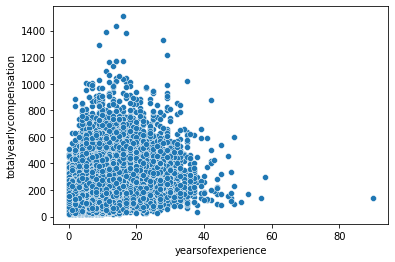

In [246]:
plot = scatterplot(x="yearsofexperience", y="totalyearlycompensation", data=copy_df)

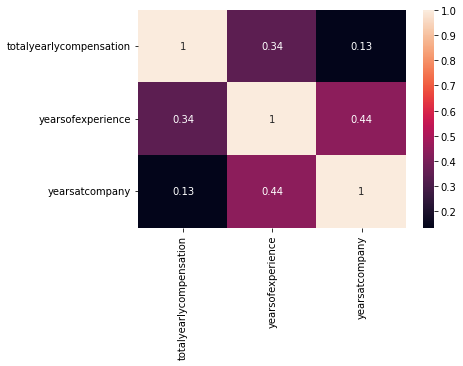

In [247]:
heatmap(copy_df.corr(), annot=True)

## So with these plots we can see that years of experience and years at company is somewhat correlated to TYC while cityId isnt, which is what we'd expect

## Lets try to engineer some features
- Honestly nothing in particular sticks out as obvious to do here maybe something like proportion of career at current company, we can try that 

In [248]:
copy_df["ratioatcurrentcompany"] = copy_df["yearsofexperience"] / (copy_df["yearsatcompany"]) 

# Data Preprosessing

In [249]:
copy_df.columns

Index(['company', 'level', 'title', 'totalyearlycompensation', 'location',
       'yearsofexperience', 'yearsatcompany', 'tag', 'gender',
       'ratioatcurrentcompany'],
      dtype='object')

In [250]:
class InsertRatio(BaseEstimator, TransformerMixin):

    def __init__(self, insert=True):
        self.insert = insert
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        if self.insert:
            X["ratioatcurrentcompany"] = copy_df["yearsofexperience"] / (copy_df["yearsatcompany"]) 
            
            # If the new feature is intended to replace the existing ones, 
            # you could drop the existing ones here
            # X.drop(["flarea", "bthrms", "bdrms"], axis=1)
    
            X = X.replace( [ np.inf, -np.inf ], np.nan )
        return X

## Now we create our Preprossesor, specifiying for out num_features we want to replace NaNs with the mean (althought there shouldnt be any NaNs left) and replace nom_features with the mode

In [251]:
# define our numeric and nominal features
features = [ 'yearsatcompany', 'yearsofexperience','company', 'level','title','location','tag','gender']
numeric_features = [ 'yearsatcompany', 'yearsofexperience']
nominal_features = ['company', 'level','title','location','tag','gender']

preprocessor = ColumnTransformer([
        ("num", Pipeline([("ratioatcurrentcompany", InsertRatio()),
                          ("imputer", SimpleImputer(missing_values=np.nan, strategy="mean")),
                          ("scaler", StandardScaler())]), 
                numeric_features),
        ("nom", Pipeline([("imputer", SimpleImputer(missing_values=np.nan, strategy="most_frequent")), 
                          ("binarizer", OneHotEncoder(handle_unknown="ignore"))]), 
                nominal_features)],
        remainder="passthrough")

In [252]:
# Extract the features but leave as a DataFrame
dev_X = dev_df[features]
test_X = test_df[features]

# Target values, converted to a 1D numpy array
dev_y = dev_df["totalyearlycompensation"].values
test_y = test_df["totalyearlycompensation"].values

# This class will allow we to test different methods of scaling via gridsearch to find the most accurate

In [253]:
class MetaTransformer(BaseEstimator, TransformerMixin):

    def __init__(self, transformer=None):
        self.transformer = transformer
        
    def fit(self, X, y=None):
        if self.transformer:
            self.transformer.fit(X, y)
        return self
    
    def transform(self, X, y=None):
        if self.transformer:
            return self.transformer.transform(X)
        else:
            return X

## We can first try KNN
- doing a grid search to find the best option for out hyperparametres and also to decide to use my custom column or not 
- Ive found it isn't useful to add my column, so im going to remove that code for the sake of completion time 

In [254]:
# Create a pipeline that combines the preprocessor with kNN
knn = Pipeline([
    ("preprocessor", preprocessor),
    ("predictor", KNeighborsRegressor())])

# Create a dictionary of hyperparameters for kNN
knn_param_grid = {"predictor__n_neighbors": [5,10,15]}

# Create the grid search object which will find the best hyperparameter values based on validation error
knn_gs = GridSearchCV(knn, knn_param_grid, scoring="neg_mean_absolute_error", cv=10, refit=True)

# Run grid search by calling fit. It will also re-train on train+validation using the best parameters.
knn_gs.fit(dev_X, dev_y)

# Let's see how well we did
knn_gs.best_params_, knn_gs.best_score_

({'predictor__n_neighbors': 15}, -63.65810177013369)

## Now lets try Ridge Regressession

In [255]:
# Create a pipeline that combines the preprocessor with ridge regression
ridge = Pipeline([
    ("preprocessor", preprocessor),
    ("predictor", Ridge())])

# Create a dictionary of hyperparameters for rideg regression
# ridge_param_grid = { "preprocessor__num__scaler__transformer": [StandardScaler(), MinMaxScaler(), RobustScaler()],
#                      "predictor__alpha": [0, 45.0, 55.0]}

ridge_param_grid = {"predictor__alpha": [0.0, 2.0,  5.0, 7.0, 10.0, 15.0,20.0]}

# Create the grid search object which will find the best hyperparameter values based on validation error
ridge_gs = GridSearchCV(ridge, ridge_param_grid, scoring="neg_mean_absolute_error", cv=10, refit=True)

# Run grid search by calling fit. It will also re-train on train+validation using the best parameters.
ridge_gs.fit(dev_X, dev_y)

# Let's see how well we did
ridge_gs.best_params_, ridge_gs.best_score_

({'predictor__alpha': 7.0}, -58.446618909794076)

# And with Ordinary linear regression

In [256]:
# Create a pipeline that combines the preprocessor with linear regression
ols = Pipeline([
    ("preprocessor", preprocessor),
    ("predictor", LinearRegression())])

# Create a dictionary of hyperparameters
ols_param_grid = {
}

# Create the grid search object which will find the best hyperparameter values based on validation error
ols_gs = GridSearchCV(ols, ols_param_grid, scoring="neg_mean_absolute_error", cv=10, refit=True)

# Run grid search by calling fit. . It will also re-train on train+validation using the best parameters.
ols_gs.fit(dev_X, dev_y)

# Let's see how well we did
ols_gs.best_params_, ols_gs.best_score_

({}, -58.75921711649512)

In [257]:
# knn.set_params(**knn_gs.best_params_) 
# scores = cross_validate(knn, dev_X, dev_y, cv=10, 
#                         scoring="neg_mean_absolute_error", return_train_score=True)
# print("Training error: ", np.mean(np.abs(scores["train_score"])))
# print("Validation error: ", np.mean(np.abs(scores["test_score"])))

KeyboardInterrupt: ignored

In [258]:
ridge.set_params(**ridge_gs.best_params_) 
scores = cross_validate(ridge, dev_X, dev_y, cv=10, 
                        scoring="neg_mean_absolute_error", return_train_score=True)
print("Training error: ", np.mean(np.abs(scores["train_score"])))
print("Validation error: ", np.mean(np.abs(scores["test_score"])))

Training error:  57.511567589041626
Validation error:  58.446618909794076


In [259]:

scores = cross_validate(ols, dev_X, dev_y, cv=10, 
                        scoring="neg_mean_absolute_error", return_train_score=True)
print("Training error: ", np.mean(np.abs(scores["train_score"])))
print("Validation error: ", np.mean(np.abs(scores["test_score"])))

Training error:  57.45311038069328
Validation error:  58.75921711649512


#Evaluate the test set
- using ridge given that it is the most accurate on our validation set

In [260]:
# Now we test on the test set
mean_absolute_error(test_y, ridge_gs.predict(test_X))


57.61157784600891

## So on average we are 57,000 off from the actual salary, which is terrible, but ill save it nonetheless

In [ ]:
ridge_gs.fit(df[features], df["totalyearlycompensation"].values)
dump(knn, 'models/my_model.pkl') 